# ASSIGNMENT 3 - Team 8

## Headers

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split

## Assumptions

* According to the pre-processing problem statement, we have assumed that we have to first prune out the transactions with the `movie ratings less than 2`. Further to that, we have pruned out those transactions where the Users have `rated less than 10 different movies`

* In Part 3, we're using `ALL rules` rather than just the common rules

## Data Pre-processing

In [10]:
df = pd.read_csv("ml-latest-small/ratings.csv")

# rating of the movies should be greater than 2
df = df[df["rating"] > 2]

# keeping only those users with more than 10 movies rated
user_counts = df.groupby("userId")["movieId"].count()
valid_users = user_counts[user_counts > 10].index
df = df[df["userId"].isin(valid_users)]

# breaking the data into train and test (20% for testing for EACH user)
train_set = {}
test_set = {}

for user, group in df.groupby("userId"):
    train, test = train_test_split(group, test_size=0.2, random_state=42)
    train_set[user] = list(train["movieId"])
    test_set[user] = list(test["movieId"])

user_movies = df.groupby("userId")["movieId"].apply(list).to_dict()

## Functions Implemented

In [11]:
# association rule mining functions
def support(movies):
    matching_users = [
        user for user in train_set if all(movie in train_set[user] for movie in movies)
    ]
    return len(matching_users) / len(train_set)


# frequent itemset generation function
def generate_frequent_itemsets(k, minsup, prev_frequent_itemsets, all_movies_sup):
    # base case / starting case
    if k == 1:
        return [([movie], sup) for movie, sup in all_movies_sup.items()]

    # otherwise
    candidates = set()
    for i in range(len(prev_frequent_itemsets)):
        for j in range(i + 1, len(prev_frequent_itemsets)):
            itemset1 = set(prev_frequent_itemsets[i][0])
            itemset2 = set(prev_frequent_itemsets[j][0])
            new_itemset = itemset1.union(itemset2)
            if len(new_itemset) == k:
                candidates.add(tuple(sorted(new_itemset)))

    return [
        (list(itemset), support(itemset))
        for itemset in candidates
        if support(itemset) >= minsup
    ]


# association rule generation function
def generate_association_rules(frequent_itemsets, minconf):
    rules = []
    for itemset, sup in frequent_itemsets:
        # making a rule only if itemset has more than 1 items
        if len(itemset) > 1:
            for i in range(len(itemset)):
                antecedent = [itemset[i]]
                consequent = [item for j, item in enumerate(itemset) if j != i]
                conf = sup / support(antecedent)
                if conf >= minconf:
                    rules.append((antecedent, consequent, sup, conf))
    return rules

## Part 1

In [12]:
# setting our own parameters
minsup = 0.11
minconf = 0.21

# getting unique movies in the training set
movies_train_unique = set(
    movie for user_movies in train_set.values() for movie in user_movies
)

# calculating support for individual movies
all_movies_sup = {
    movie: support([movie])
    for movie in movies_train_unique
    if support([movie]) >= minsup
}

# generating frequent itemsets
frequent_itemsets = [generate_frequent_itemsets(1, minsup, [], all_movies_sup)]
k = 2
while True:
    frequent_k = generate_frequent_itemsets(
        k, minsup, frequent_itemsets[-1], all_movies_sup
    )
    if not frequent_k:
        break
    frequent_itemsets.append(frequent_k)
    k += 1

# now generating association rules
all_rules = []
for itemsets in frequent_itemsets[1:]:  # Start from 2-itemsets
    all_rules.extend(generate_association_rules(itemsets, minconf))

# filtering and keeping rules where X contains a single movie
final_rules = [rule for rule in all_rules if len(rule[0]) == 1]

# sorting out the rules by confidence
sorted_rules = sorted(final_rules, key=lambda x: x[3], reverse=True)

# printing all the rules found
print(
    f"Number of association rules found: {len(sorted_rules)}\n\nThey are as follows :"
)
for rule in sorted_rules:
    print(f"{rule[0]} -> {rule[1]} (Support: {rule[2]:.4f}, Confidence: {rule[3]:.4f})")

Number of association rules found: 669

They are as follows :
[153] -> [592] (Support: 0.1170, Confidence: 0.7802)
[1221] -> [858] (Support: 0.1219, Confidence: 0.7789)
[1527] -> [2571] (Support: 0.1120, Confidence: 0.7727)
[1240] -> [2571] (Support: 0.1252, Confidence: 0.7677)
[5952] -> [7153] (Support: 0.1713, Confidence: 0.7536)
[4993] -> [7153] (Support: 0.1779, Confidence: 0.7248)
[5952] -> [4993] (Support: 0.1647, Confidence: 0.7246)
[1089] -> [296] (Support: 0.1203, Confidence: 0.7228)
[1196] -> [260] (Support: 0.1928, Confidence: 0.7222)
[3793] -> [2571] (Support: 0.1236, Confidence: 0.7212)
[1291] -> [2571] (Support: 0.1236, Confidence: 0.7075)
[7153] -> [4993] (Support: 0.1779, Confidence: 0.7059)
[2762] -> [2571] (Support: 0.1565, Confidence: 0.6985)
[1291] -> [1198] (Support: 0.1219, Confidence: 0.6981)
[1210] -> [260] (Support: 0.1664, Confidence: 0.6966)
[2329] -> [2959] (Support: 0.1203, Confidence: 0.6952)
[79132] -> [318] (Support: 0.1170, Confidence: 0.6893)
[8961] ->

## Part 2

In [13]:
# helper function : to convert a rule to a fully hashable format
def rule_to_hashable(rule):
    return (tuple(rule[0]), tuple(rule[1]), rule[2], rule[3])


# sorting rules by support (descending order)
top_100_support = sorted(final_rules, key=lambda x: x[2], reverse=True)[:100]

# creating a file to store the top 100 rules by support
with open("8_top100RulesBySup.txt", "w") as f:
    for rule in top_100_support:
        f.write(
            f"{rule[0]} -> {rule[1]} (Support: {rule[2]:.4f}, Confidence: {rule[3]:.4f})\n"
        )

# sorting rules by confidence (descending order)
top_100_confidence = sorted(final_rules, key=lambda x: x[3], reverse=True)[:100]

# creating a file to store the top 100 rules by confidence
with open("8_top100RulesByConf.txt", "w") as f:
    for rule in top_100_confidence:
        f.write(
            f"{rule[0]} -> {rule[1]} (Support: {rule[2]:.4f}, Confidence: {rule[3]:.4f})\n"
        )

# finding common rules in both sets
common_rules = set(rule_to_hashable(rule) for rule in top_100_support) & set(
    rule_to_hashable(rule) for rule in top_100_confidence
)

# sorting again by confidence
common_rules_sorted = sorted(common_rules, key=lambda x: x[3], reverse=True)

# printing all the results
print(f"Number of common rules: {len(common_rules)}\n\n")
print("Common rules sorted by confidence:")
for i, rule in enumerate(common_rules_sorted, 1):
    print(
        f"{i}) {rule[0]} -> {rule[1]} (Support: {rule[2]:.4f}, Confidence: {rule[3]:.4f})"
    )

Number of common rules: 30


Common rules sorted by confidence:
1) (5952,) -> (7153,) (Support: 0.1713, Confidence: 0.7536)
2) (4993,) -> (7153,) (Support: 0.1779, Confidence: 0.7248)
3) (5952,) -> (4993,) (Support: 0.1647, Confidence: 0.7246)
4) (1196,) -> (260,) (Support: 0.1928, Confidence: 0.7222)
5) (7153,) -> (4993,) (Support: 0.1779, Confidence: 0.7059)
6) (2762,) -> (2571,) (Support: 0.1565, Confidence: 0.6985)
7) (1210,) -> (260,) (Support: 0.1664, Confidence: 0.6966)
8) (2028,) -> (2571,) (Support: 0.1713, Confidence: 0.6842)
9) (7153,) -> (5952,) (Support: 0.1713, Confidence: 0.6797)
10) (4993,) -> (5952,) (Support: 0.1647, Confidence: 0.6711)
11) (1198,) -> (2571,) (Support: 0.1697, Confidence: 0.6603)
12) (47,) -> (296,) (Support: 0.1631, Confidence: 0.6600)
13) (1210,) -> (2571,) (Support: 0.1565, Confidence: 0.6552)
14) (1210,) -> (1196,) (Support: 0.1565, Confidence: 0.6552)
15) (1196,) -> (2571,) (Support: 0.1746, Confidence: 0.6543)
16) (7153,) -> (2571,) (Support: 0.

## Part 3

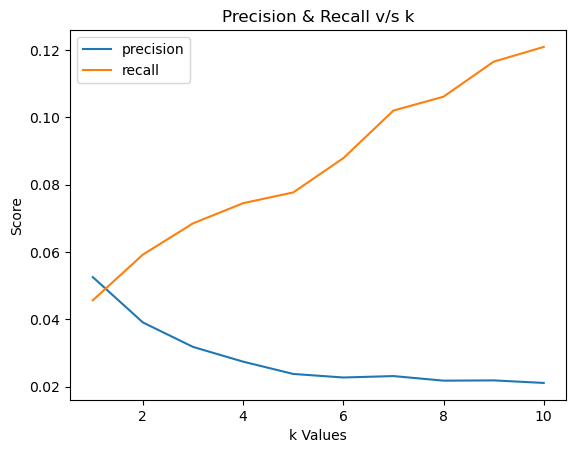

In [14]:
precision_avgs = []
recall_avgs = []

# iterating over the number of rules selected from the Top Rules
for k in range(1, 11):
    # iterating over each user in the test set
    all_precisions = []
    all_recalls = []
    for user in test_set.keys():
        # getting all movies rated by this user from the training set
        user_movies_from_train_set = train_set[user]

        # getting predictions set
        predictions = list()
        for movie in user_movies_from_train_set:
            rules_taken_count = 0
            temp_predictions = []

            # iterating over top k rules only
            for rule in sorted_rules:
                if rule[0][0] == movie:
                    temp_predictions += rule[1]
                    rules_taken_count += 1

                    # checking if top k done
                    if rules_taken_count == k:
                        break

            # adding temp predictions to the main predictions
            predictions += temp_predictions

        # calculating recall
        user_recall = len(set(test_set[user]) & set(predictions)) / len(test_set[user])
        all_recalls.append(user_recall)

        # calculating precision
        user_precision = 0
        if len(predictions) != 0:
            user_precision = len(set(test_set[user]) & set(predictions)) / len(
                predictions
            )
        all_precisions.append(user_precision)

    # calculating average precision and recall
    precision_avg_for_k = np.mean(all_precisions)
    recall_avg_for_k = np.mean(all_recalls)

    # adding to the list
    precision_avgs.append(precision_avg_for_k)
    recall_avgs.append(recall_avg_for_k)

# plotting graph
x = [i for i in range(1, 11)]
plt.title("Precision & Recall v/s k")
plt.plot(x, precision_avgs, label="precision")
plt.plot(x, recall_avgs, label="recall")
plt.legend()
plt.xlabel("k Values")
plt.ylabel("Score")
plt.show()

## Reasoning & Inference

__Increasing Recall :__\
Conversely, as the number of rules (k) increases, the average recall is likely to improve. This is because a larger set of rules results in more recommendations, increasing the likelihood of including relevant items from the test set. Recall measures the proportion of relevant items that are successfully recommended, and as the number of recommendations grows, so does the chance of covering a greater portion of the relevant items.

__Decreasing Precision :__\
As the number of rules (k) increases, the average precision is likely to decrease. This occurs because a larger set of rules leads to more recommendations, some of which may not be relevant to the user. Consequently, precision, which measures the proportion of relevant items among the recommended ones, tends to decline as k increases.

__Trade-off Between Precision & Recall :__\
The relationship between precision and recall typically exhibits a trade-off. When fewer rules are used (lower k), you tend to achieve higher precision but lower recall. Conversely, when more rules are applied (higher k), you generally obtain higher recall but lower precision. This trade-off is often visualized in a graph showing the inverse relationship between these two metrics as the number of rules changes. This happens because increasing the number of rules increases the number of recommendations, which can include both relevant and irrelevant items.

## Part 4

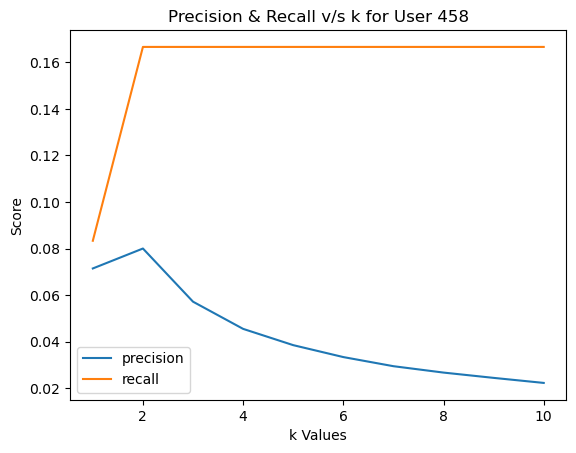

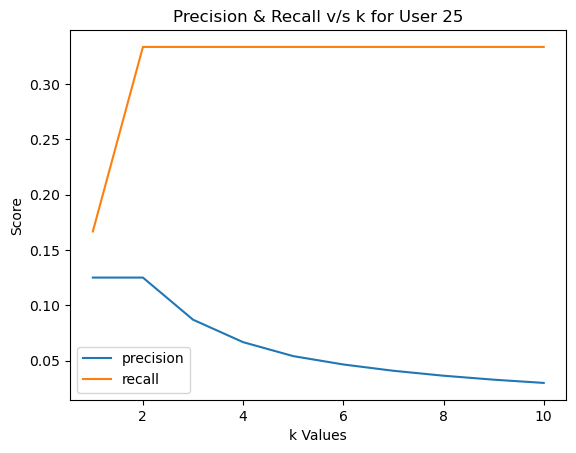

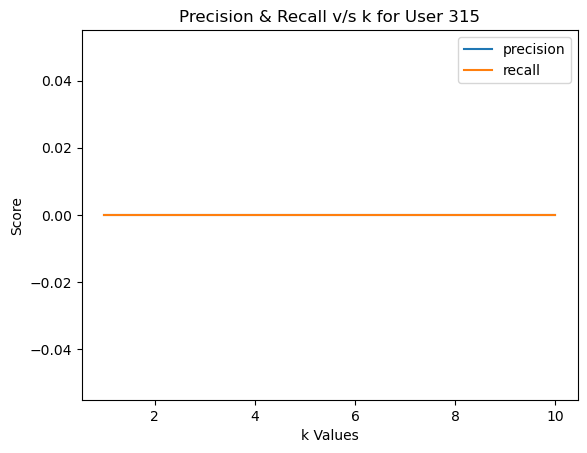

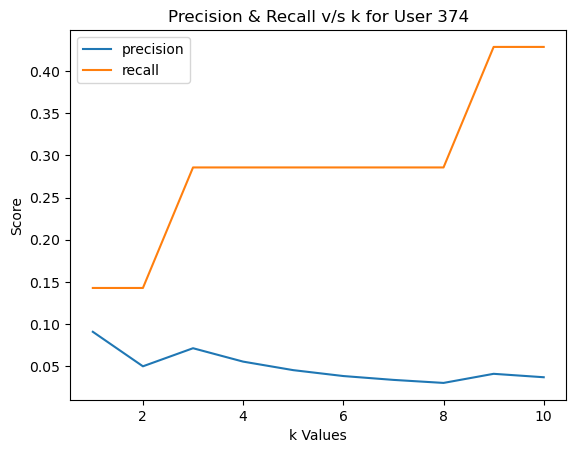

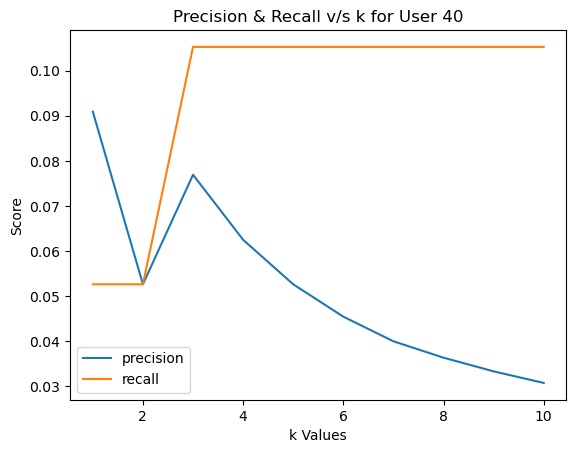

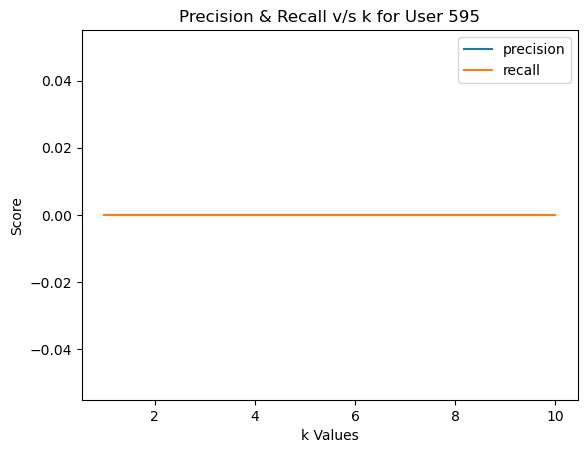

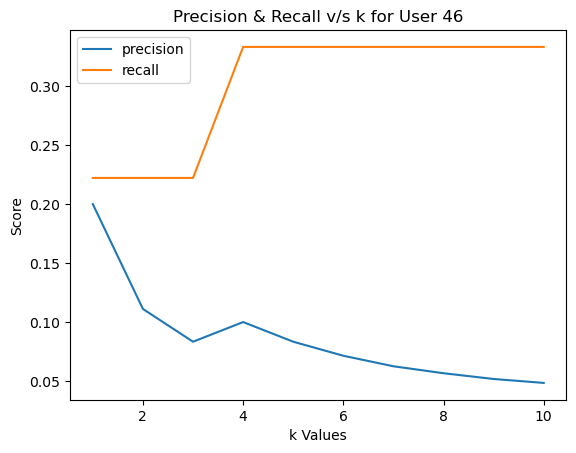

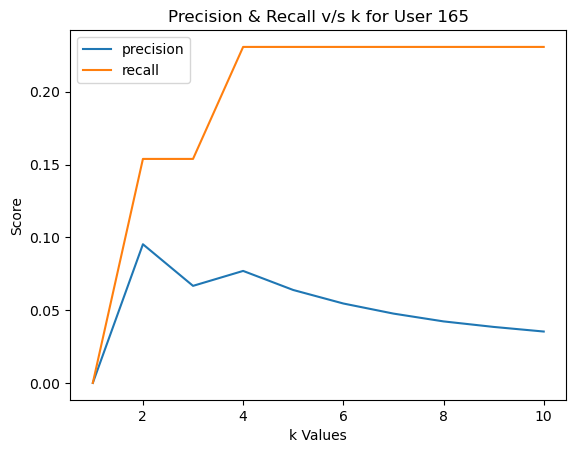

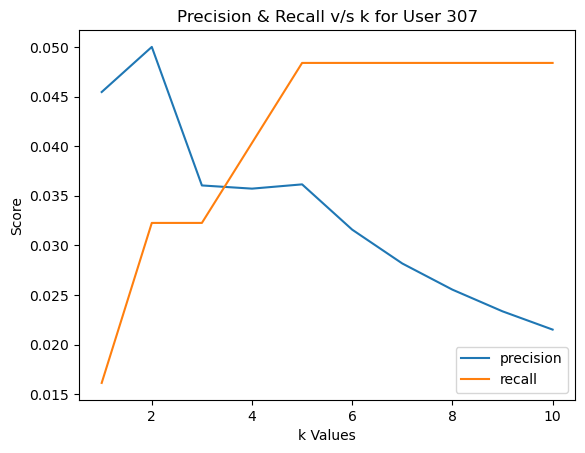

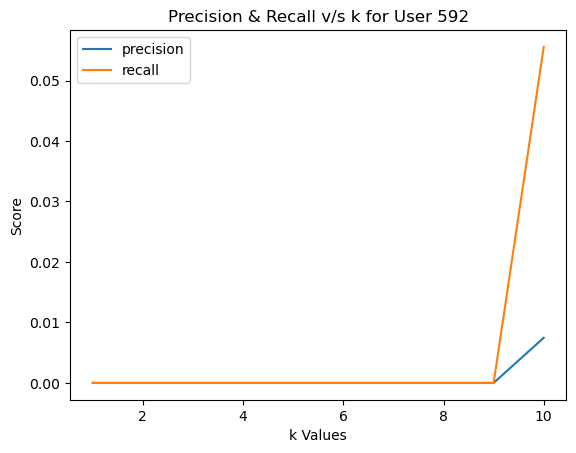

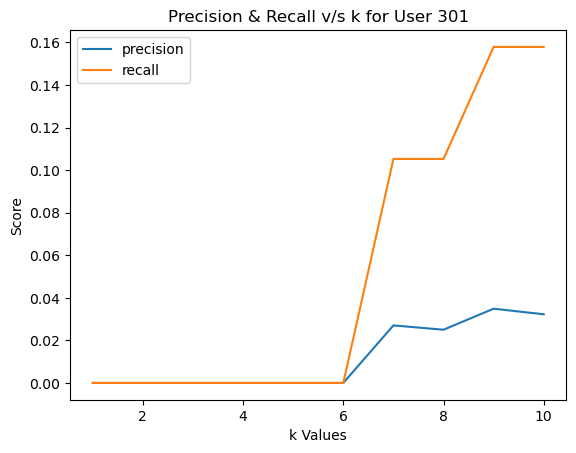

In [15]:
"""
- Doing the same as above but for EACH user rather than averaging out for all users.
- For that, sampling some random 11 users everytime this cell is ran.
"""

# getting list of random 11 users
random_users = random.sample(list(test_set.keys()), 11)

# iterating over each user
for user in random_users:
    all_recalls = []
    all_precisions = []

    # iterating over k values
    for k in range(1, 11):
        # getting all movies rated by this user from the training set
        user_movies_from_train_set = train_set[user]

        # getting predictions set
        predictions = list()
        for movie in user_movies_from_train_set:
            rules_taken_count = 0
            temp_predictions = []

            # iterating over top k rules only
            for rule in sorted_rules:
                if rule[0][0] == movie:
                    temp_predictions += rule[1]
                    rules_taken_count += 1

                    # checking if top k done
                    if rules_taken_count == k:
                        break

            # adding temp predictions to the main predictions
            predictions += temp_predictions

        # calculating recall
        user_recall = len(set(test_set[user]) & set(predictions)) / len(test_set[user])
        all_recalls.append(user_recall)

        # calculating precision
        user_precision = 0
        if len(predictions) != 0:
            user_precision = len(set(test_set[user]) & set(predictions)) / len(
                predictions
            )
        all_precisions.append(user_precision)

    # plotting graph for THIS user
    x = [i for i in range(1, 11)]
    plt.plot(x, all_precisions, label="precision")
    plt.plot(x, all_recalls, label="recall")
    plt.legend()
    plt.xlabel("k Values")
    plt.ylabel("Score")
    plt.title(f"Precision & Recall v/s k for User {user}")
    plt.show()